# Import Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set visualization style
sns.set(style="whitegrid")

# Load Dataset

In [19]:
df = pd.read_csv('Uber_Data.csv')
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (354, 4)


,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


# Inspect Data

In [20]:
print("\nColumn Names:")
print(df.columns)

print("\nMissing Values:")
print(df.isnull().sum())

print("\nData Types:")
print(df.dtypes)



Column Names:
Index(['dispatching_base_number', 'date', 'active_vehicles', 'trips'], dtype='object')

Missing Values:
dispatching_base_number    0
date                       0
active_vehicles            0
trips                      0
dtype: int64

Data Types:
dispatching_base_number    object
date                       object
active_vehicles             int64
trips                       int64
dtype: object


# Preprocessing — Convert Date and Create Time Features

In [22]:
# Rename to ensure consistency
df.rename(columns={'Date': 'date'}, inplace=True)

# Convert to datetime
df['date'] = pd.to_datetime(df['date'])

# Create time-based features
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday  # Monday=0
df['week'] = df['date'].dt.isocalendar().week


# Exploratory Data Analysis (EDA)

## Total Trips Over Time

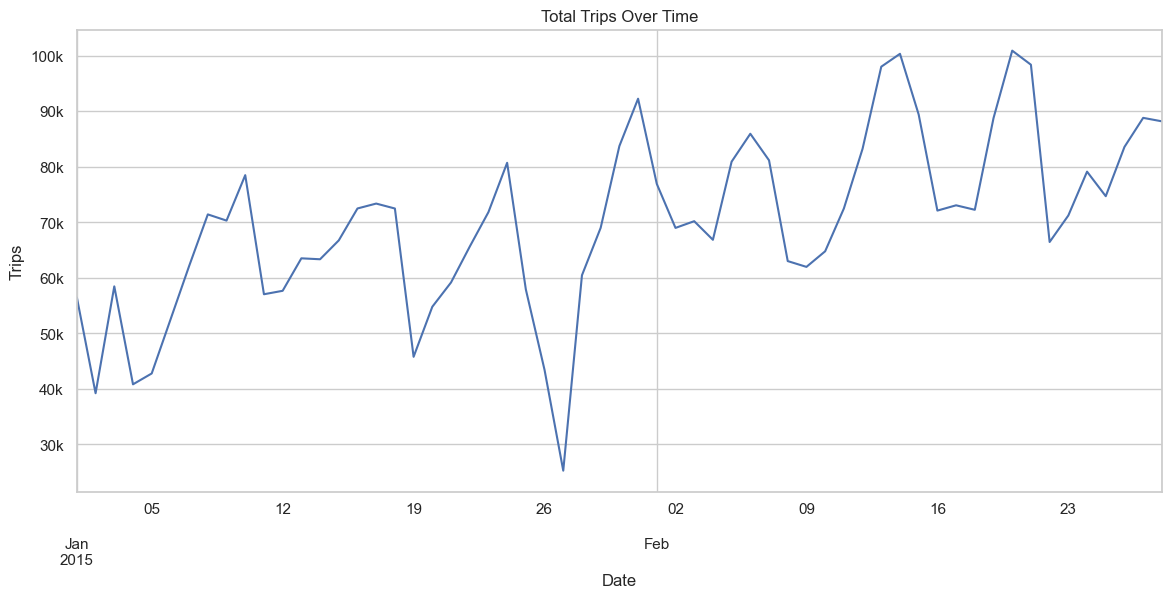

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to convert y-axis labels to 'k'
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

df.groupby('date')['trips'].sum().plot(
    figsize=(14, 6), 
    title='Total Trips Over Time'
)

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Format y-axis
plt.xlabel('Date')
plt.ylabel('Trips')
plt.show()


## Active Vehicles Over Time

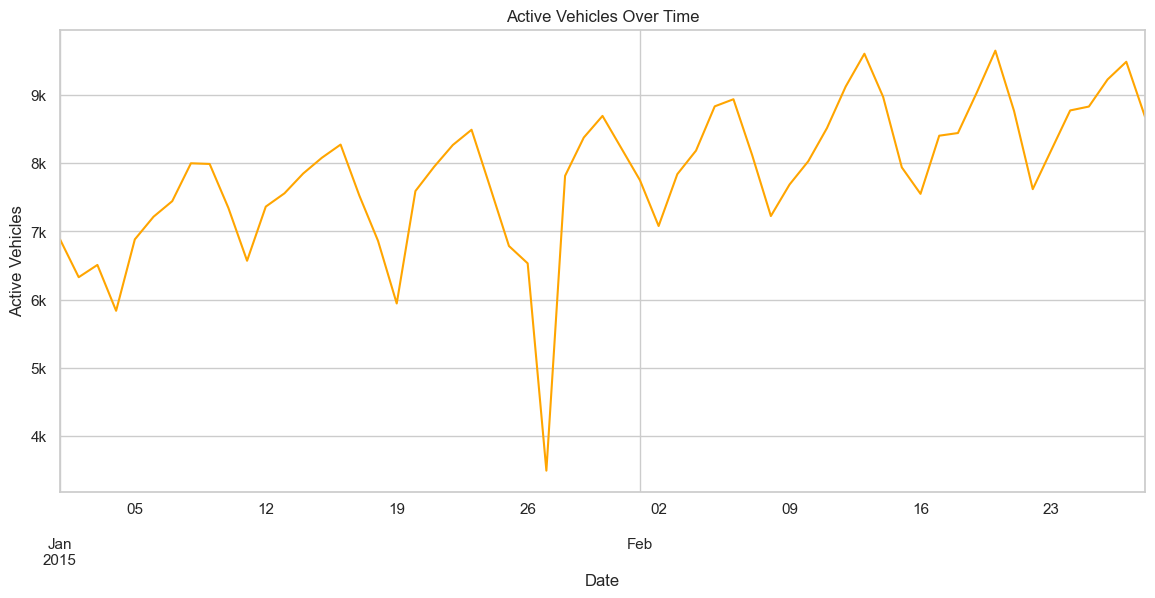

In [36]:
# Formatter function for 'k' format
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

df.groupby('date')['active_vehicles'].sum().plot(
    figsize=(14, 6),
    color='orange',
    title='Active Vehicles Over Time'
)

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Apply formatter
plt.xlabel('Date')
plt.ylabel('Active Vehicles')
plt.show()

## Trips per Base

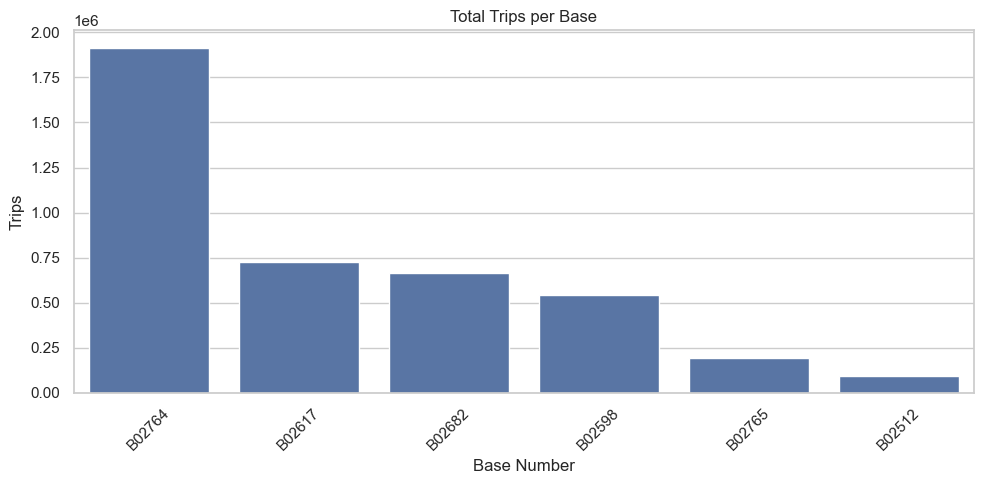

In [26]:
base_trips = df.groupby('dispatching_base_number')['trips'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=base_trips.index, y=base_trips.values)
plt.title('Total Trips per Base')
plt.xlabel('Base Number')
plt.ylabel('Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Feature Engineering

In [27]:
# Trips per vehicle (basic efficiency metric)
df['trips_per_vehicle'] = df['trips'] / df['active_vehicles']
df['trips_per_vehicle'] = df['trips_per_vehicle'].replace([np.inf, -np.inf], np.nan).fillna(0)


# Modeling — Predicting Trips

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Feature selection
features = ['day', 'month', 'year', 'weekday', 'week', 'active_vehicles']
X = df[features]
y = df['trips']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: 0.9767031969117421
RMSE: 1584.9560070540035


# Residuals Plot

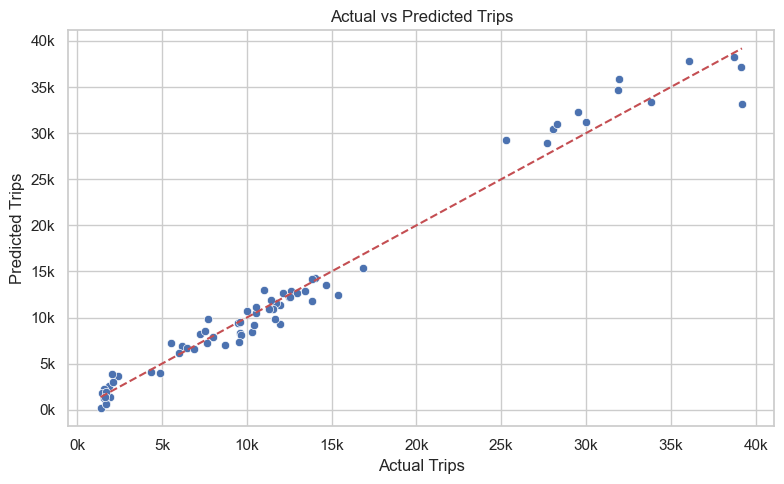

In [37]:

# Formatter function for 'k' format
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Trips")
plt.ylabel("Predicted Trips")
plt.title("Actual vs Predicted Trips")

# Diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Format axes
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.tight_layout()
plt.show()



# Save Cleaned Data

In [30]:
df.to_csv("cleaned_uber_data.csv", index=False)